#**Discovering Symbolic Models from Deep Learning with Inductive Biases**
## Implementazione del [modello originale proposto dagli autori](https://github.com/MilesCranmer/symbolic_deep_learning).

Contestabile Giorgio, De Mei Vincenzo, Macaluso Nicolò

[Link alla cartella GitHuB contenente codici e risultati del presente lavoro](https://github.com/gitNoYokai/symbolic_deep_learning_GNV)

Il progetto qui proposto vuole mostrare come sia possibile convertire una rete neurale in una semplice equazione analitica.
Gli autori hanno ritenuto opportuno suddividere la discussione in due blocchi principali: 

1.   una prima parte di codice dove vengono simulati sistemi di particelle interagenti tramite uno specifico potenziale (scelto dall'utente) ed ogni evento viene memorizzato sotto forma di un grafo dove le particelle vanno a costituire i nodi. Dagli edge vengono estrapolate le informazioni sull'interazione, dunque segue un allenamento della rete sui valori dell'accelerazione;   
2.   una seconda parte contenente la regressione simbolica dei risultati ottenuti dalla simulazione. Il risultato finale è l'equazione della forza associata alla specifica interazione presa in considerazione.




# 1. Preambolo e Simulazione

### Importazione delle librerie di base

In [3]:
# Basic pre-reqs:
import numpy as np
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
version_nums = torch.__version__.split('.')
# Torch Geometric seems to always build for *.*.0 of torch :
version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
 
!pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 35.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 34.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 5.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=d44d6dff834e596cec0b8f6815b8efb1041ef222a4225d8f11f4485b66625d6f
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [6]:
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py -O models.py
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py -O simulate.py

--2022-11-08 15:21:10--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9647 (9.4K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   9.42K  --.-KB/s    in 0s      

2022-11-08 15:21:10 (56.5 MB/s) - ‘models.py’ saved [9647/9647]

--2022-11-08 15:21:10--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9752 (9.5K) [text/p

### Importazione delle librerie per la modellizzazione della rete (**models**) e per le simulazioni fisiche (**simulate**)

In [7]:
import models
import simulate

In [8]:
torch.ones(1).cuda()

tensor([1.], device='cuda:0')

### Scelta della simulazione

In [9]:
# Number of simulations to run (it's fast, don't worry):
ns = 10000
# Potential (see below for options)
sim = 'spring'
# Number of nodes
n = 4
# Dimension
dim = 2
# Number of time steps
nt = 1000


#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

Running on spring_n=4_dim=2_nt=1000_dt=0.01


### Generazione dei dati della simulazione

In [10]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

In [11]:
data = s.data
s.data.shape

(10000, 500, 4, 6)

### Visualizzazione della simulazione

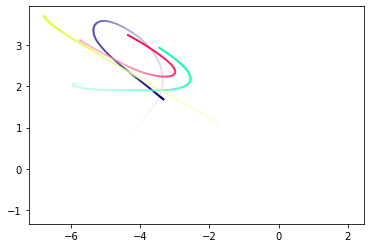

In [12]:
s.plot(0, animate=True, plot_size=False)

### Preparazione dei dati

In [13]:
accel_data = s.get_acceleration()

In [14]:
X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)]))

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# 2. Impostazione della Rete e Training

In [17]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [18]:
from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

### Scelta della Loss Function

Per applicare **Bottleneck**, è necessario porre la dimensionalità del messaggi pari a quella del sistema.

In [19]:
aggr = 'add'
hidden = 300

test = '_l1_'

#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]

### Note degli Autori sulle Loss Function

L1 loss: we simply add the loss to the batch number. I.e., * 32 for batch size 32.

KL loss: model the messages as a distribution with the prior a Gaussian. The means add in the final Gaussian. 
Recall in the D_KL(p||q), the prior is q.  Then, for sigma_q = 1, mu_q = 0, we have ($p=1$):

$$D_{KL}(p||q) = \frac{\sigma_p^2 + \mu_p^2}{2} -\log({\sigma_p}) - \frac{1}{2}$$

### Data Loader personalizzato scelto dagli Autori

In [20]:
from torch_geometric.data import Data, DataLoader

In [21]:
from models import get_edge_index

In [22]:
edge_index = get_edge_index(n, sim)

### Inizializzazione del modello

In [23]:
if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

messages_over_time = []
ogn = ogn.cuda()

In [24]:
_q = Data(
    x=X_train[0].cuda(),
    edge_index=edge_index.cuda(),
    y=y_train[0].cuda())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

(tensor([[0.0070, 0.0128],
         [0.0106, 0.0144],
         [0.0248, 0.0148],
         [0.0118, 0.0144]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([4, 2]),
 torch.Size([4, 2]),
 tensor(24.7356, device='cuda:0', grad_fn=<SumBackward0>))

### Organizzazione dei dati

In [25]:
batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

### Definizione delle Loss Function

In [27]:
def new_loss(self, g, augment=True, square=False):
    if square:
        return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
    else:
        base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
        if test in ['_l1_', '_kl_']:
            s1 = g.x[self.edge_index[0]]
            s2 = g.x[self.edge_index[1]]
            if test == '_l1_':
                m12 = self.message(s1, s2)
                regularization = 1e-2
                #Want one loss value per row of g.y:
                normalized_l05 = torch.sum(torch.abs(m12))
                return base_loss, regularization * batch * normalized_l05 / n**2 * n
            elif test == '_kl_':
                regularization = 1
                #Want one loss value per row of g.y:
                tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
                raw_msg = self.msg_fnc(tmp)
                mu = raw_msg[:, 0::2]
                logvar = raw_msg[:, 1::2]
                full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
                return base_loss, regularization * batch * full_kl / n**2 * n
        return base_loss

### Impostazione dei parametri per il training

Per vari potenziali, 150-200 epoche sono sufficienti per ottenere buoni risultati. 

A fine puramente illustrativo, gli autori impostano la simulazione con sole 30 epoche.

In [28]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

#total_epochs = 200
total_epochs = 30

batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

5000

In [29]:
epoch = 0

from tqdm import tqdm

### Organizzazione dei messaggi

In [30]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

# Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

### Funzione per la registrazione dell'output della rete

In [31]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

In [32]:
recorded_models = []

### Ciclo di Training

In [ ]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cuda()
            ginput.y = ginput.y.cuda()
            ginput.edge_index = ginput.edge_index.cuda()
            ginput.batch = ginput.batch.cuda()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  3%|▎         | 1/30 [00:38<18:29, 38.28s/it]

12.40893366909027


### Salvataggio dei risultati

Per evitare di dover ripetere il training si salvano i messaggi (ed eventualmente si caricano quelli già prodotti) in formato .pkl

In [ ]:
import pickle as pkl
pkl.dump(messages_over_time,
    open('messages_over_time.pkl', 'wb'))
messages_over_time = pkl.load(open('messages_over_time.pkl', 'rb'))

In [ ]:
pkl.dump(recorded_models,
    open('models_over_time.pkl', 'wb'))

recorded_models = pkl.load(open('models_over_time.pkl', 'rb'))

# 3. Analisi

In [ ]:
from celluloid import Camera
from copy import deepcopy as copy

### Analisi grafica dei risultati

Sono disponibili tre differenti grafici:

* Messaggi in funzione delle forze
* Messaggi in funzione del tempo in scala di grigi
* Rappresentazione rotazionale dei messaggi


In [ ]:

# Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        # if sim != 'spring':
        #     raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        # force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        # print(msgs)
        # print(msgs[['q1', 'q2']])
        if sim == 'spring':
            force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        elif sim == 'charge':
            force_fnc = lambda msg: np.array(msg[['q1']]) * np.array(msg[['q2']]) * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 3)
        # elif sim == 'discontinuous':
        #     force_fnc = lambda msg: 0 if((msg.bd < 2))[:, None] else (msg.bd - 1)**2[:, None]
        else:
            raise NotImplementedError("For this simulation no force is implemented.")
        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
cam.animate().save('force_vs_msg_2.mp4')

from IPython.display import HTML
HTML(ani.to_jshtml())

### Visualizzazione delle traiettorie

Nella figura di destra:

* i cerchi colorati sono le traiettorie predette;
* i cerchi grigi sono le traiettorie simulate.

In [ ]:
from simulate import make_transparent_color
from scipy.integrate import odeint

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
    i = 4 #Use this simulation
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    if current_model > -1:
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        y = y.reshape(5, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, 5, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()

camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())

In [ ]:
camera.animate().save('multiple_animations_with_comparison.mp4')

# 4. Preparazione alla Regressione Simbolica

Extract the force laws with the following procedure:
- The data in `messages_over_time` correspond to inputs to, and features of, $\phi^e$, recorded during each training epoch.
- Select the last element of this list.
- Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.

Train [PySR](https://github.com/MilesCranmer/PySR) to fit this relationship.
Thus, we have extracted a force law from the graph network without priors on the functional form.

This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations.


### Selezione del messaggio migliore

Il messaggio migliore viene convertito in file .csv per comodità. La regressione simbolica viene comunque eseguita nella seconda parte del presente notebook.

In [ ]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']].to_csv("spring_best_messages.csv")

#**Regressione simbolica**
Il presente codice esegue la regressione simbolica dei dati prodotti dalla rete neurale nel precendente blocco.

Lo scopo è quello di trovare la funzione che meglio descrive la forza del sistema fisico preso in considerazione.

Come primo passo, viene installato Julia.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done
  
  julia -e 'println("Success")'
fi

In [ ]:
#%pip install -Uq pysr pytorch_lightning

In [ ]:
#from julia import Julia

#julia = Julia(compiled_modules=False)
#from julia import Main
#from julia.tools import redirect_output_streams

#redirect_output_streams()


Viene visualizzato l'ultimo elemento dell'array di messaggi prodotti dal modello.

In [ ]:
messages_over_time[-1]

Viene selezionata la migliore componente dell'array di messaggi. Se nel training è stato usato un modello bottleneck, le componenti tra cui scegliere saranno due (pari alla dimensionalità del sistema fisico in questione).
Nel caso di regularization loss l1, la dimensionalità del messaggio è di 100 componenti.

In [ ]:
import numpy as np

best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)]) 

Viene quindi visualizzato il migliore messaggio.

In [ ]:
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

Si installa PySR.

In [ ]:

pip install pysr


Obiettivo della regressione simbolica: cercare una relazione tra le variabili "dx, dy, r, m1..." e la migliore componente del messaggio (ovvero della forza).
Le variabili indipendenti sono "dx, dy, r,...",
mentre la variabile dipendente è la componente migliore del messaggio.

In [ ]:
from pysr import PySRRegressor


In [ ]:
best = messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

In [ ]:
X = best[['dx', 'dy', 'r', 'm1', 'm2']]
Y = best[['e%d'%(best_message,)]]

Qui si costruisce il modello per la regressione. In particolare:

1) model_selection seleziona il modello migliore in base ad una combinazione di semplicità e accuratezza;

2) viene dichiarato il numero di interazioni dell'algoritmo;

3) è possibile, selezionando "binary_operators" o "unary_operators", forzare il sistema a scegliere all'interno di un insieme di operatori dati;

4) "select_k_features = somenumber" è un comando che impone al modello di non usare tutte le variabili date (dx, dy, r, m1, m2, q1, q2), ma di scegliere le più significative per la regressione;

5) viene definita la funzione di loss che dovrà quantificare la bontà dei modelli sviluppati.




In [ ]:
model = PySRRegressor(
    model_selection="best",
    niterations=200,
     binary_operators=["+", "*","-","/"],
     #unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
     unary_operators=["square", "cube"],
     #extra_sympy_mappings={"inv": lambda x: 1/x, "inv_q": lambda x: 1/x^2, "inv_cub": lambda x: 1/x^3},
     select_k_features=3,
    loss="L1DistLoss()",
    batching=True
)

model.fit(X, Y)

Viene stampato il modello, anche sotto forma di tabella in linguaggio LaTeX.

In [ ]:
print(model)

In [ ]:
print(model.latex_table())

In [ ]:
X[["r","m1"]].shape


Viene infine stampata la funzione con il miglior score.

In [ ]:
pysr_model.simpy()